<a href="https://colab.research.google.com/github/Barabaika/Transcript_course_2022/blob/main/HW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашнее задание

Сделайте NextFlow пайплайн, который будет подсчитывать принимать на вход аргументом список SRA-идентефикаторов эксперимента, а на выход давать подсчитанные экспрессии. Путь к индексу kallisto тоже будет подаваться на вход отдельно как аргумент.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from scipy.special import logsumexp
import scipy.stats as stats


Добавить к пайплайу из первого задания еще kallisto

Модифицируйте EM-алгоритм таким образом, чтобы он находил не два, а три кластера на наших данных.

In [160]:
import numpy as np
from scipy.special import logsumexp

def get_random_psd(n=2):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())


def E_step(X, params, draw=False):


  LogLikelihood = A = np.log([
      stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(X), 
      stats.multivariate_normal(params["mu2"], params["sigma2"]).pdf(X),
      stats.multivariate_normal(params["mu3"], params["sigma3"]).pdf(X)
  ])
  logPrior = B = np.log([1- (params["phi"][0] + params["phi"][1]), params["phi"][0], params["phi"][1]])
  logPosterior = D = logPrior + LogLikelihood.T
  RealSoftMax = C = logsumexp(logPosterior, axis=1)
  probabilities = np.exp(logPosterior - np.array([RealSoftMax]).T)

  if draw:
    hist1 = stats.multivariate_normal(params["mu1"], params["sigma1"]).rvs(size=1000)
    hist2 = stats.multivariate_normal(params["mu2"], params["sigma2"]).rvs(size=1000)
    hist3 = stats.multivariate_normal(params["mu3"], params["sigma3"]).rvs(size=1000)

    fig, axes = plt.subplots(figsize=(6, 3), dpi=150, ncols=2)
    # sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=probabilities[:, 0], linewidth=0,
    #                 palette="coolwarm", ax=axes[1], s=3, alpha=1)
    # sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=probabilities[:, 0:2], linewidth=0,
    #                 palette="pastel", ax=axes[1], s=3, alpha=1)
    
    sns.scatterplot(x=X[:, 0], y=X[:, 1], linewidth=0, ax=axes[0], s=3, alpha=1, color="grey")
    sns.kdeplot(x=hist1[:, 0], y=hist1[:, 1], ax=axes[0], cmap="Reds", fill=True, alpha=0.5)
    sns.kdeplot(x=hist2[:, 0], y=hist2[:, 1], ax=axes[0], cmap="Blues", fill=True, alpha=0.5)
    sns.kdeplot(x=hist3[:, 0], y=hist3[:, 1], ax=axes[0], cmap="Greens", fill=True, alpha=0.5)

    axes[0].grid(alpha=0.3)
    axes[1].grid(alpha=0.3)
    axes[1].legend().remove()
    axes[0].set_xlim(-4, 4)
    axes[1].set_xlim(-4, 4)
    axes[0].set_ylim(-4, 4)
    axes[1].set_ylim(-4, 4)
    plt.show()

  return RealSoftMax, probabilities

def M_step(X, params, probabilities):
  prob_1 = probabilities[:, 0]
  prob_2 = probabilities[:, 1]
  prob_3 = probabilities[:, 2]

  # Вычисление новых значений
  # Пропорция = prior
  phi = [prob_1.sum() / len(X), prob_2.sum() / len(X)]

  # Среднее
  mu1 = prob_1.dot(X) / np.sum(prob_1)
  mu2 = prob_2.dot(X) / np.sum(prob_2)
  mu3 = prob_3.dot(X) / np.sum(prob_3)

  # Дисперсия
  sigma1 = (X - mu1).T.dot((X - mu1) * np.array([prob_1]).T) / np.sum(prob_1)
  sigma2 = (X - mu2).T.dot((X - mu2) * np.array([prob_2]).T) / np.sum(prob_2)
  sigma3 = (X - mu3).T.dot((X - mu3) * np.array([prob_3]).T) / np.sum(prob_3)
  
  return {
      "phi" : phi,
      "mu1" : mu1, "mu2" : mu2, 'mu3': mu3,
      "sigma1": sigma1, "sigma2": sigma2, "sigma3": sigma3
  }

def run_EM(X, params, draw=False):
    import imageio
    avg_allprob = []

    while True:
        allprob, probabilities = E_step(X, params, draw=draw)
        avg_allprob.append(np.mean(allprob))
        if len(avg_allprob) > 2 and abs(avg_allprob[-1] - avg_allprob[-2]) < 0.1:
            break
        params = M_step(X, params, probabilities)
        
    loglikelihood, probabilities = E_step(X, params)
    forecasts = np.argmax(probabilities, axis=1)
    return forecasts, probabilities, avg_allprob

phi:
[0.56699237 0.06314682 0.36986081] 

mu1:
[-0.07797545  0.71582272] 

mu2:
[-0.61612095  1.47818205] 

mu3:
[1.04416626 0.8544297 ] 

sigma1:
[[ 0.27762544 -0.72165612]
 [-0.72165612  2.73013536]] 

sigma2:
[[1.51171189 0.08352188]
 [0.08352188 0.24314395]] 

sigma3:
[[3.66553962 5.42155582]
 [5.42155582 8.41630265]] 



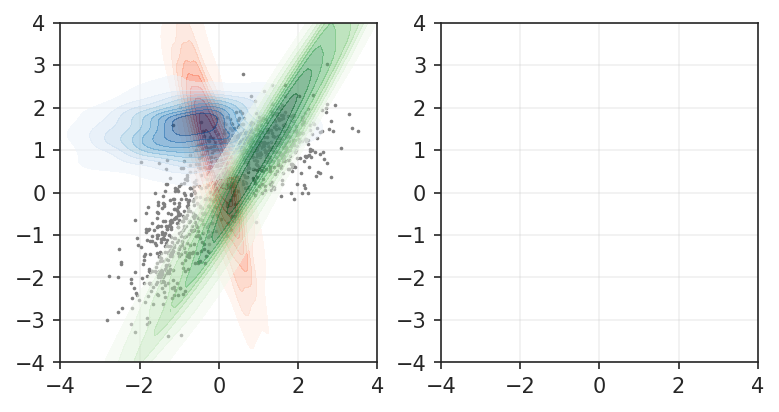

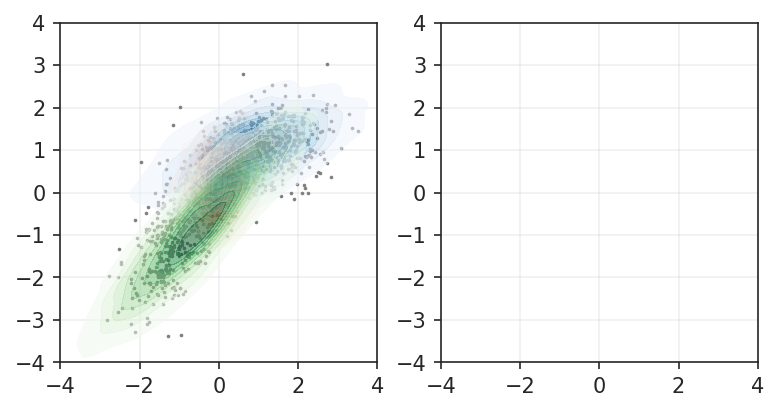

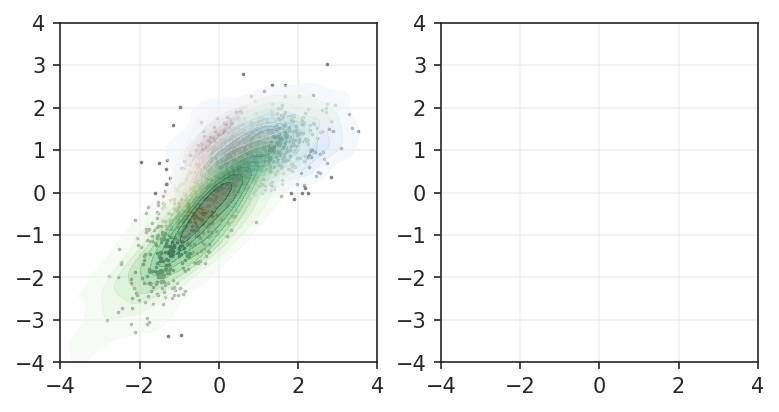

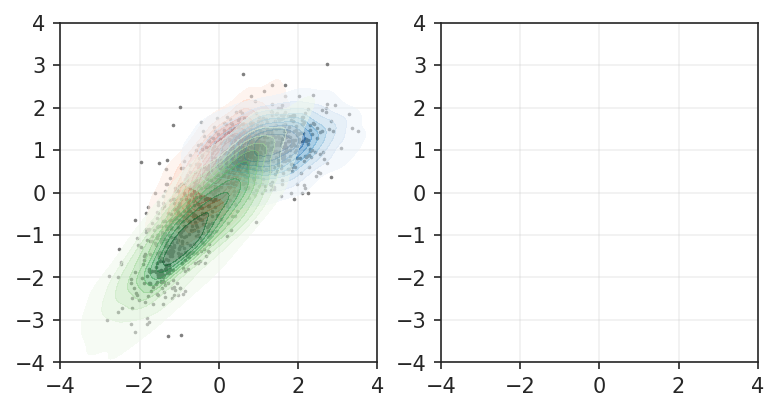

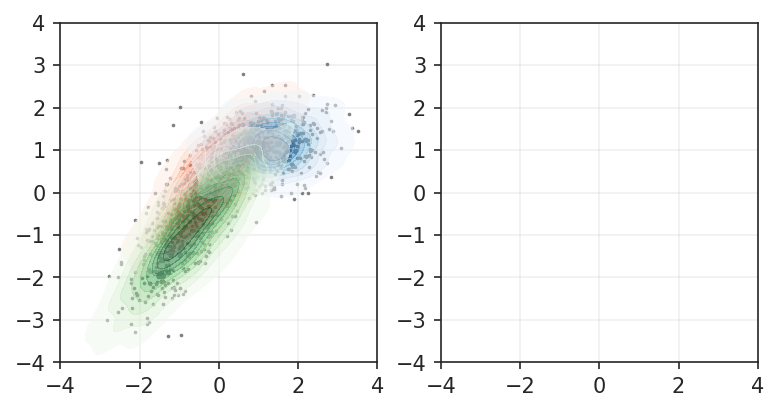

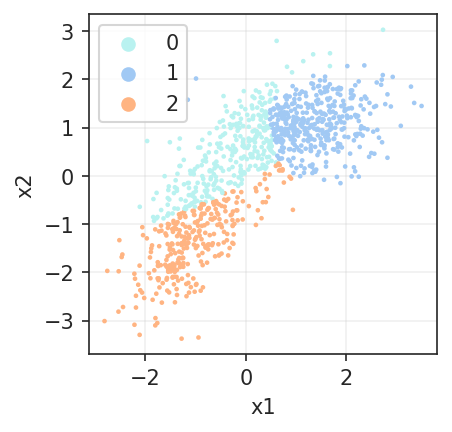

In [161]:
params = {
    "phi" : np.random.dirichlet(np.ones(3),size=1)[0], # Доля точек, принадлежащих к кластеру 1, 2, 3

    "mu1" : np.random.normal(0, 1, size=2), # Центр распределения 1
    "mu2" : np.random.normal(0, 1, size=2), # Центр распределения 2
    "mu3" : np.random.normal(0, 1, size=2), # Центр распределения 2
    
    "sigma1": get_random_psd(), # У 2d Гауссианы таким образом задаётся дисперсия
    "sigma2" : get_random_psd(), # У 2d Гауссианы таким образом задаётся дисперсия
    "sigma3" : get_random_psd() # У 2d Гауссианы таким образом задаётся дисперсия
}

for param in params:
  print(f"{param}:")
  print(params[param], "\n")
X = df.values

pred, prob, allprob = run_EM(X, params, draw=True)

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, linewidth=0, ax=ax, hue=pred,
                palette={0: sns.color_palette("pastel", n_colors=50)[-1],
                         1: sns.color_palette("pastel", n_colors=50)[0],
                         2: sns.color_palette("pastel", n_colors=50)[1]})
ax.grid(alpha=0.3)

Попробуйте сами написать алгоритм, который будет при помощи EM-алгоритма оценивать представленность экспрессию транскриптов (необязательно работать с графами или прочтениями, можете упростить ситуацию до модельной).

In [229]:
n_blocks = 9
n_isoforms = 6
transcripts = {
    "A" : [0, 1, 2],
    "B" : [1, 2, 3],
    "C" : [1, 4, 5],
    "D" : [5],
    "E" : [5, 6],
    "F" : [7, 8]
}

transcripts_list = list(transcripts.values())

E = {
    "A" : 100,
    "B" : 100,
    "C" : 30,
    "D" : 0,
    "E" : 20,
    "F" : 10
}

# предположим что разделились риды разномерно между всеми блоками для каждого транскрипта
E_per_blocks = []
for ind, tr in enumerate(transcripts.keys()):
  E_per_blocks.append(E[tr]/len(transcripts[tr]))

reads_per_block = []

for block in range(N_blocks):
  reads_per_block.append(
      sum(
          [E_per_blocks[tr_ind] for tr_ind in isoforms_each_block[block]]
      )
  )


In [250]:
class EM():
  def __init__(
      self,
      n_isoforms, 
      n_blocks, 
      transcripts_list, 
      reads_per_block
      ):
    
    self.n_isoforms =  n_isoforms
    self.n_blocks = n_blocks
    self.transcripts_list = transcripts_list
    self.reads_per_block = reads_per_block
    self.isoforms_each_block = [
      [
          tr_ind for tr_ind, tr in enumerate(transcripts_list) if block in tr
       ] for block in range(n_blocks)
    ]
    
    self.probs = self.init_params(n_isoforms)
    self.reads_per_iso_block = np.zeros((n_isoforms, n_blocks))

    self.history = np.array([self.probs])

  def init_params(self, n_isoforms):
    return np.array([1/n_isoforms]*n_isoforms)

  def e_step(self):
    for isoform in range(self.n_isoforms):
      for iso_block in self.transcripts_list[isoform]:
        if len(self.isoforms_each_block[iso_block]) > 1:
          self.reads_per_iso_block[isoform, iso_block] = self.reads_per_block[iso_block]*self.probs[isoform] 
        else:
          self.reads_per_iso_block[isoform, iso_block] = self.reads_per_block[iso_block]
      
      # imporant to divide by the len of the transcript (isoform)
      self.reads_per_iso_block[isoform, :] = self.reads_per_iso_block[isoform, :] / len(self.transcripts_list[isoform])

    reads_per_iso = np.sum(self.reads_per_iso_block, axis = 1)
    return reads_per_iso

  def m_step(self, reads_per_iso):
    self.probs = reads_per_iso/sum(reads_per_iso)
    self.history = np.vstack([self.history, self.probs])

  def conv_check(self):
    if len(self.history) > 2 and np.sum(np.abs(self.history[-1, :] - self.history[-2, :])) < 0.00001:
      return False
    else:
      return True


  def run_em(self, print_step_logs):
    step = 0
    while self.conv_check():
      if print_step_logs:

        print(f'step {str(step)}: predicted abundances for each isoform: {self.probs.round(3)}')
      reads_per_iso = self.e_step()
      self.m_step(reads_per_iso)
      step +=1 

    print(f'STOP: final predicted abundances for each isoform: {self.probs.round(3)}')

In [251]:
EM_ = EM(n_isoforms, n_blocks, transcripts_list, reads_per_block)

In [252]:
EM_.run_em(print_step_logs = True)

step 0: predicted abundances for each isoform: [0.167 0.167 0.167 0.167 0.167 0.167]
step 1: predicted abundances for each isoform: [0.308 0.308 0.141 0.054 0.108 0.081]
step 2: predicted abundances for each isoform: [0.36  0.36  0.11  0.015 0.085 0.07 ]
step 3: predicted abundances for each isoform: [0.379 0.379 0.092 0.004 0.078 0.067]
step 4: predicted abundances for each isoform: [0.387 0.387 0.083 0.001 0.076 0.066]
step 5: predicted abundances for each isoform: [0.389 0.389 0.079 0.    0.076 0.066]
step 6: predicted abundances for each isoform: [0.391 0.391 0.077 0.    0.076 0.066]
step 7: predicted abundances for each isoform: [0.391 0.391 0.077 0.    0.076 0.066]
step 8: predicted abundances for each isoform: [0.391 0.391 0.076 0.    0.076 0.066]
step 9: predicted abundances for each isoform: [0.391 0.391 0.076 0.    0.076 0.066]
step 10: predicted abundances for each isoform: [0.391 0.391 0.076 0.    0.076 0.066]
step 11: predicted abundances for each isoform: [0.391 0.391 0.0

In [253]:
E_truth = dict(zip(E.keys(), np.array(list(E.values()))/sum(list(E.values()))))
E_pred = dict(zip(E.keys(), EM_.probs))

pd.DataFrame({'True':E_truth, 'Pred':E_pred})

,True,Pred
A,0.384615,3.914567e-01
B,0.384615,3.914567e-01
C,0.115385,7.586416e-02
D,0.000000,1.667175e-09
E,0.076923,7.557257e-02
F,0.038462,6.564988e-02
